# GCP Bigquery with GCP Functions and GPT actions in ChatGPT

This notebook provides step-by-step instructions on using Google Cloud BigQuery as a database with vector search capabilities, with OpenAI embeddings, then creating a Google Cloud Function on top to plug into a Custom GPT in ChatGPT.

This can be a solution for customers looking to set up RAG infrastructure contained within Google Cloud Platform (GCP), and exposing it as an endpoint to integrate that with other platforms such as ChatGPT.

Google Cloud BigQuery is a fully-managed, serverless data warehouse that enables super-fast SQL queries using the processing power of Google's infrastructure. It allows developers to store and analyze massive datasets with ease.

Google Cloud Functions is a lightweight, event-based, asynchronous compute solution that allows you to create small, single-purpose functions that respond to cloud events without managing servers or runtime environments.

## Pre-requisites:

To run this cookbook, you must have:
- A GCP project you have access to
- GCP user with permission to create a BigQuery dataset and Google Cloud Function
- [GCP CLI](https://cloud.google.com/sdk/docs/downloads-interactive) installed and connected
- OpenAI API key
- ChatGPT Plus, Teams or Enterprise subscription


## Architecture

Below is a diagram of the architecture of this solution, which we'll walk through step-by-step:

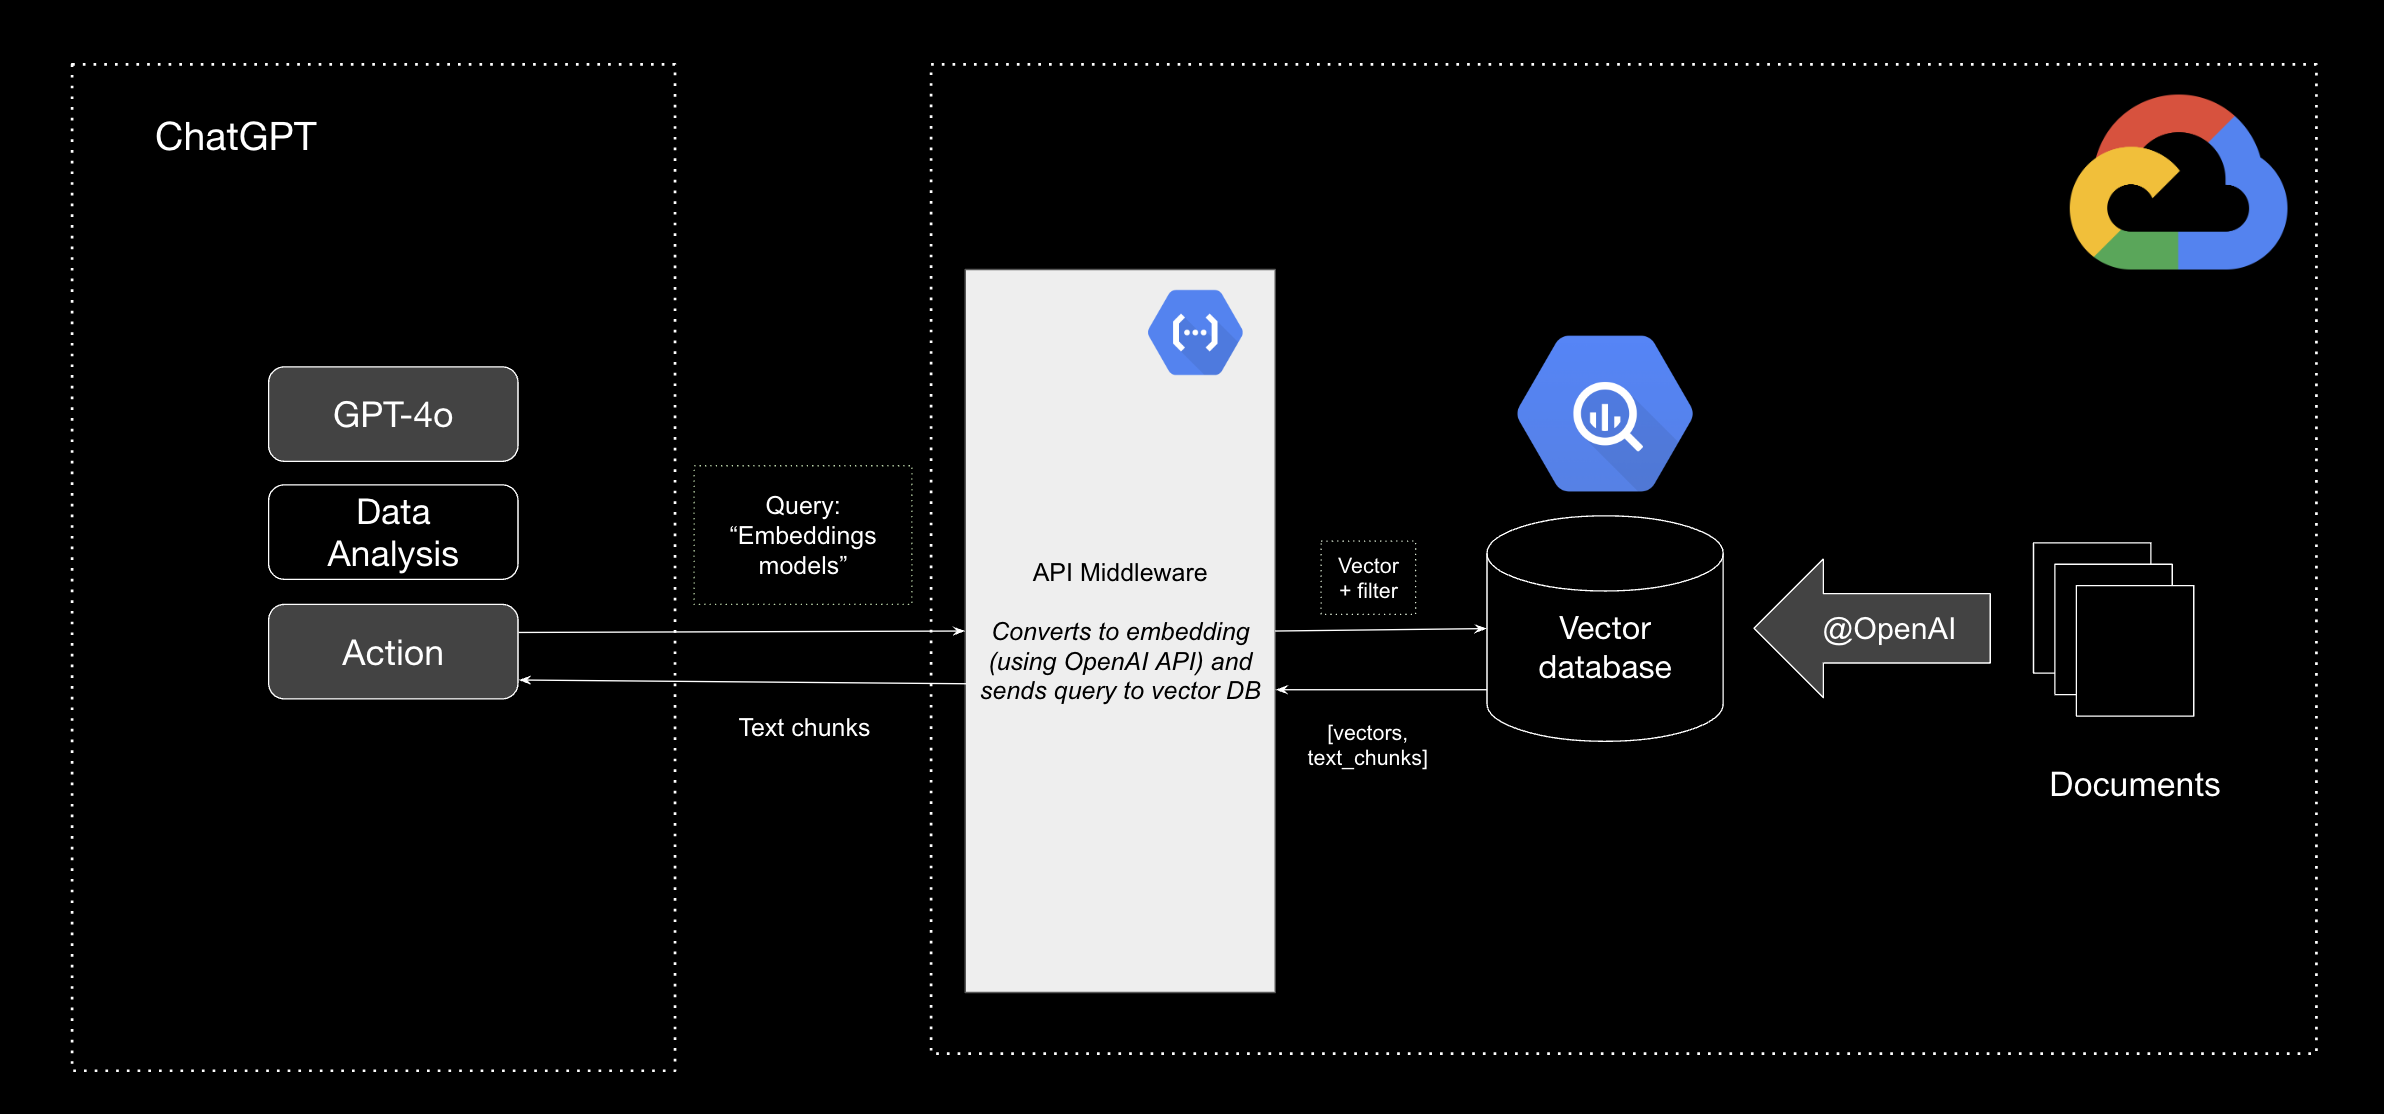

## Table of Contents

1. **[Setup of Environment](#set-up-environment)** Setup environment by installing and importing the required libraries and configuring our GCP settings. Includes:
- [Install and Import Required Libraries](#install-and-import-required-libraries)
- [Configure GCP project](#configure-gcp-project)
- [Configure OpenAI Settings](#configure-openai-settings)


2. **[Prepare Data](#prepare-data)** Prepare the data for uploading by embedding the documents, as well as capturing additional metadata. We will use a subset of OpenAI's docs as example data for this.

3. **[Create BigQuery Table with Vector search](#create-bigquery-table-with-vector-search)**  
Create a BigQuery table and upload the data we've prepared. Includes:

- [Create Dataset](#create-bigquery-dataset): Steps to create a dataset in BigQuery.
- [Create Table and upload data](#creating-table-and-upload-data): Instructions to create a table in BigQuery.

4. **[Create GCP Function](#create-gcp-function)** using gcloud CLI and environment variables computed previously

5. **[Input in a Custom GPT in ChatGPT](#input-in-a-custom-gpt-in-chatgpt)** Perform searches on the embedded data in BigQuery:

- [Vector Search](#test-search): Steps to perform vector-based search queries.
- [Metadata filtering Search](#perform-search-with-metadata-filtering): Instructions for performing metadata filtering.

# Set up environment

## Install and import required libraries
The below libraries can be categorized as standard Python libraries, third-party libraries, and GCP-related libraries.

In [ ]:
! pip install -q google-auth
! pip install -q openai
! pip install -q pandas
! pip install -q google-cloud-functions
! pip install -q python-dotenv
! pip install -q pyperclip
! pip install -q PyPDF2
! pip install -q tiktoken
! pip install -q google-cloud-bigquery
! pip install -q pyyaml

In [ ]:
# Standard Libraries
import json  
import os
import csv
import shutil
from itertools import islice
import concurrent.futures
import yaml

# Third-Party Libraries
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader
import tiktoken
from dotenv import load_dotenv
import pyperclip

# OpenAI Libraries
from openai import OpenAI

# Google Cloud Identity and Credentials
from google.auth import default
from google.cloud import bigquery
from google.cloud import functions_v1


## Configure GCP project

If not already set-up, we'll install GCP CLI's, authenticate to GCP and set your default project.

In [ ]:
# Add gcloud to PATH
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/google-cloud-sdk/bin')

# Verify gcloud is in PATH
! gcloud --version

In [ ]:
! gcloud auth application-default login

In [ ]:
project_id = "<insert_project_id>"  # Replace with your actual project ID
! gcloud config set project {project_id}

In [ ]:
! gcloud services enable cloudfunctions.googleapis.com
! gcloud services enable cloudbuild.googleapis.com
! gcloud services enable bigquery.googleapis.com

## Configure OpenAI settings

This section guides you through setting up authentication for  OpenAI. Before going through this section, make sure you have your OpenAI API key.

In [ ]:
openai_api_key = os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as an env var>") # Saving this as a variable to reference in function app in later step
openai_client = OpenAI(api_key=openai_api_key)
embeddings_model = "text-embedding-3-small" # We'll use this by default, but you can change to your text-embedding-3-large if desired

## Configure GCP BigQuery with Vector Search capabilities

This section explains how to create a dataset in BigQuery and store vectors of float, used for embeddings & vector search.

In [ ]:
from google.auth import default

# Use default credentials
credentials, project_id = default()
region = "us-central1" # e.g: "us-central1"
print("Default Project ID:", project_id)

# Prepare data
We're going to embed and store a few pages of the OpenAI docs in the oai_docs folder. We'll first embed each, add it to a CSV, and then use that CSV to upload to the index.

We are going to use some techniques highlighted in [this cookbook](khttps://github.com/openai/openai-cookbook/blob/main/examples/Embedding_long_inputs.ipynb). This is a quick way to embed text, without taking into account variables like sections, using our vision model to describe images/graphs/diagrams, overlapping text between chunks for longer documents, etc. 

In order to handle longer text files beyond the context of 8191 tokens, we can either use the chunk embeddings separately, or combine them in some way, such as averaging (weighted by the size of each chunk).

We will take a function from Python's own cookbook that breaks up a sequence into chunks.

In [ ]:
def batched(iterable, n):
    """Batch data into tuples of length n. The last batch may be shorter."""
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch


Now we define a function that encodes a string into tokens and then breaks it up into chunks. We'll use tiktoken, a fast open-source tokenizer by OpenAI.

To read more about counting tokens with Tiktoken, check out [this cookbook](https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken). 



In [ ]:
def chunked_tokens(text, chunk_length, encoding_name='cl100k_base'):
    # Get the encoding object for the specified encoding name. OpenAI's tiktoken library, which is used in this notebook, currently supports two encodings: 'bpe' and 'cl100k_base'. The 'bpe' encoding is used for GPT-3 and earlier models, while 'cl100k_base' is used for newer models like GPT-4.
    encoding = tiktoken.get_encoding(encoding_name)
    # Encode the input text into tokens
    tokens = encoding.encode(text)
    # Create an iterator that yields chunks of tokens of the specified length
    chunks_iterator = batched(tokens, chunk_length)
    # Yield each chunk from the iterator
    yield from chunks_iterator

Finally, we can write a function that safely handles embedding requests, even when the input text is longer than the maximum context length, by chunking the input tokens and embedding each chunk individually. The average flag can be set to True to return the weighted average of the chunk embeddings, or False to simply return the unmodified list of chunk embeddings.

> Note: there are other techniques you can take here, including:
> - using GPT-4o to capture images/chart descriptions for embedding
> - chunking based on paragraphs or sections
> - adding more descriptive metadata about each article.

In [ ]:
EMBEDDING_CTX_LENGTH = 8191
EMBEDDING_ENCODING='cl100k_base'

In [ ]:
def generate_embeddings(text, model):
    # Generate embeddings for the provided text using the specified model
    embeddings_response = openai_client.embeddings.create(model=model, input=text)
    # Extract the embedding data from the response
    embedding = embeddings_response.data[0].embedding
    return embedding

def len_safe_get_embedding(text, model=embeddings_model, max_tokens=EMBEDDING_CTX_LENGTH, encoding_name=EMBEDDING_ENCODING):
    # Initialize lists to store embeddings and corresponding text chunks
    chunk_embeddings = []
    chunk_texts = []
    # Iterate over chunks of tokens from the input text
    for chunk in chunked_tokens(text, chunk_length=max_tokens, encoding_name=encoding_name):
        # Generate embeddings for each chunk and append to the list
        chunk_embeddings.append(generate_embeddings(chunk, model=model))
        # Decode the chunk back to text and append to the list
        chunk_texts.append(tiktoken.get_encoding(encoding_name).decode(chunk))
    # Return the list of chunk embeddings and the corresponding text chunks
    return chunk_embeddings, chunk_texts

Next, we can define a helper function that will capture additional metadata about the documents. In this example, I'll choose from a list of categories to use later on in a metadata filter

In [ ]:
categories = ['authentication','models','techniques','tools','setup','billing_limits','other']

def categorize_text(text, categories):

    # Create a prompt for categorization
    messages = [
        {"role": "system", "content": f"""You are an expert in LLMs, and you will be given text that corresponds to an article in OpenAI's documentation.
         Categorize the document into one of these categories: {', '.join(categories)}. Only respond with the category name and nothing else."""},
        {"role": "user", "content": text}
    ]
    try:
        # Call the OpenAI API to categorize the text
        response = openai_client.chat.completions.create(
            model="gpt-4o",
            messages=messages
        )

        # Extract the category from the response
        category = response.choices[0].message.content
        return category
    except Exception as e:
        print(f"Error categorizing text: {str(e)}")
        return None

# Example usage

Now, we can define some helper functions to process the .txt files in the oai_docs folder. Feel free to use this on your own data, this supports both .txt and .pdf files.

In [ ]:
def extract_text_from_pdf(pdf_path):
    # Initialize the PDF reader
    reader = PdfReader(pdf_path)
    text = ""
    # Iterate through each page in the PDF and extract text
    for page in reader.pages:
        text += page.extract_text()
    return text

def process_file(file_path, idx, categories, embeddings_model):
    file_name = os.path.basename(file_path)
    print(f"Processing file {idx + 1}: {file_name}")
    
    # Read text content from .txt files
    if file_name.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
    # Extract text content from .pdf files
    elif file_name.endswith('.pdf'):
        text = extract_text_from_pdf(file_path)
    
    title = file_name
    # Generate embeddings for the title
    title_vectors, title_text = len_safe_get_embedding(title, embeddings_model)
    print(f"Generated title embeddings for {file_name}")
    
    # Generate embeddings for the content
    content_vectors, content_text = len_safe_get_embedding(text, embeddings_model)
    print(f"Generated content embeddings for {file_name}")
    
    category = categorize_text(' '.join(content_text), categories)
    print(f"Categorized {file_name} as {category}")
    
    # Prepare the data to be appended
    data = []
    for i, content_vector in enumerate(content_vectors):
        data.append({
            "id": f"{idx}_{i}",
            "vector_id": f"{idx}_{i}",
            "title": title_text[0],
            "text": content_text[i],
            "title_vector": json.dumps(title_vectors[0]),  # Assuming title is short and has only one chunk
            "content_vector": json.dumps(content_vector),
            "category": category
        })
        print(f"Appended data for chunk {i + 1}/{len(content_vectors)} of {file_name}")
    
    return data



We'll now use this helper function to process our OpenAI documentation. Feel free to update this to use your own data by changing the folder in process_files below.

Note that this will process the documents in chosen folder concurrently, so this should take <30 seconds if using txt files, and slightly longer if using PDFs.

In [ ]:
## Customize the location below if you are using different data besides the OpenAI documentation. Note that if you are using a different dataset, you will need to update the categories list as well.
folder_name = "../../../data/oai_docs"

files = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith('.txt') or f.endswith('.pdf')]
data = []

# Process each file concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_file, file_path, idx, categories, embeddings_model): idx for idx, file_path in enumerate(files)}
    for future in concurrent.futures.as_completed(futures):
        try:
            result = future.result()
            data.extend(result)
        except Exception as e:
            print(f"Error processing file: {str(e)}")

# Write the data to a CSV file
csv_file = os.path.join("..", "embedded_data.csv")
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ["id", "vector_id", "title", "text", "title_vector", "content_vector","category"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)
        print(f"Wrote row with id {row['id']} to CSV")

# Convert the CSV file to a Dataframe
article_df = pd.read_csv("../embedded_data.csv")
# Read vectors from strings back into a list using json.loads
article_df["title_vector"] = article_df.title_vector.apply(json.loads)
article_df["content_vector"] = article_df.content_vector.apply(json.loads)
article_df["vector_id"] = article_df["vector_id"].apply(str)
article_df["category"] = article_df["category"].apply(str)
article_df.head()

We now have an `embedded_data.csv` file with six columns that we can upload to our vector database! 

# Create BigQuery table with Vector Search

## Create BigQuery dataset

We'll leverage Google SDK and create a dataset named "oai_docs" with a table name of "embedded_data", but feel free to change those variables (you can also change regions).

*PS: We won't create a BigQuery index, that could improve the performance of the vector search, because such index requires more than 1k rows in our dataset which we don't have in our example, but feel free to leverage that for your own use-case.*

In [ ]:
# Create bigquery table

from google.cloud import bigquery
from google.api_core.exceptions import Conflict

# Define the dataset ID (project_id.dataset_id)
raw_dataset_id = 'oai_docs'
dataset_id = project_id + '.' + raw_dataset_id

client = bigquery.Client(credentials=credentials, project=project_id)

# Construct a full Dataset object to send to the API
dataset = bigquery.Dataset(dataset_id)

# Specify the geographic location where the dataset should reside
dataset.location = "US"

# Send the dataset to the API for creation
try:
    dataset = client.create_dataset(dataset, timeout=30)
    print(f"Created dataset {client.project}.{dataset.dataset_id}")
except Conflict:
    print(f"dataset {dataset.dataset_id } already exists")
    

In [ ]:
# Read the CSV file, properly handling multiline fields
csv_file_path = "../embedded_data.csv"
df = pd.read_csv(csv_file_path, engine='python', quotechar='"', quoting=1)

# Display the first few rows of the dataframe
df.head()


## Creating table and upload data

We'll create the table with the attribute name and types. Note the 'content_vector' attribute that allows to store a vector of float for a single row, which we'll use for our vector search.

This code will then loop on our CSVs previously created to insert the rows into Bigquery. 
If you run this code multiple time, multiple identical rows will be inserted which will give less accurate results when doing search (you could put uniqueness on IDs or clean the DB each time).

In [ ]:
# Read the CSV file, properly handling multiline fields
dataset_id = project_id + '.' + raw_dataset_id
client = bigquery.Client(credentials=credentials, project=project_id)
csv_file_path = "../embedded_data.csv"
df = pd.read_csv(csv_file_path, engine='python', quotechar='"', quoting=1)

# Preprocess the data to ensure content_vector is correctly formatted
# removing last and first character which are brackets [], comma splitting and converting to float
def preprocess_content_vector(row):
    row['content_vector'] = [float(x) for x in row['content_vector'][1:-1].split(',')]
    return row

# Apply preprocessing to the dataframe
df = df.apply(preprocess_content_vector, axis=1)

# Define the schema of the final table
final_schema = [
    bigquery.SchemaField("id", "STRING"),
    bigquery.SchemaField("vector_id", "STRING"),
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("text", "STRING"),
    bigquery.SchemaField("title_vector", "STRING"),
    bigquery.SchemaField("content_vector", "FLOAT64", mode="REPEATED"),
    bigquery.SchemaField("category", "STRING"),
]

# Define the final table ID
raw_table_id = 'embedded_data'
final_table_id = f'{dataset_id}.' + raw_table_id

# Create the final table object
final_table = bigquery.Table(final_table_id, schema=final_schema)

# Send the table to the API for creation
final_table = client.create_table(final_table, exists_ok=True)  # API request
print(f"Created final table {project_id}.{final_table.dataset_id}.{final_table.table_id}")

# Convert DataFrame to list of dictionaries for BigQuery insertion
rows_to_insert = df.to_dict(orient='records')

# Upload data to the final table
errors = client.insert_rows_json(f"{final_table.dataset_id}.{final_table.table_id}", rows_to_insert)  # API request

if errors:
    print(f"Encountered errors while inserting rows: {errors}")
else:
    print(f"Successfully loaded data into {dataset_id}:{final_table_id}")

# Test search
Now that the data is uploaded, we'll test both pure vector similarity search and with metadata filtering locally below to make sure it is working as expected.

You can test both a pure vector search and metadata filtering.

The query below is pure vector search, where we don't filter out on category.

In [ ]:
query = "What model should I use to embed?"
category = "models"

embedding_query = generate_embeddings(query, embeddings_model)
embedding_query_list = ', '.join(map(str, embedding_query))

query = f"""
WITH search_results AS (
  SELECT query.id AS query_id, base.id AS base_id, distance
  FROM VECTOR_SEARCH(
    TABLE oai_docs.embedded_data, 'content_vector',
    (SELECT ARRAY[{embedding_query_list}] AS content_vector, 'query_vector' AS id),
    top_k => 2, distance_type => 'COSINE', options => '{{"use_brute_force": true}}')
)
SELECT sr.query_id, sr.base_id, sr.distance, ed.text, ed.title
FROM search_results sr
JOIN oai_docs.embedded_data ed ON sr.base_id = ed.id
ORDER BY sr.distance ASC
"""

query_job = client.query(query)
results = query_job.result()  # Wait for the job to complete

for row in results:
    print(f"query_id: {row['query_id']}, base_id: {row['base_id']}, distance: {row['distance']}, text_truncated: {row['text'][0:100]}")


## Perform search with metadata filtering
Metadata filtering allows to restrict findings that have certain attributes on top of having the closest semantic findings of vector search.

The provided code snippet demonstrates how to execute a query with metadata filtering:

In [ ]:

query = "What model should I use to embed?"
category = "models"

embedding_query = generate_embeddings(query, embeddings_model)
embedding_query_list = ', '.join(map(str, embedding_query))


query = f"""
WITH search_results AS (
  SELECT query.id AS query_id, base.id AS base_id, distance
  FROM VECTOR_SEARCH(
    (SELECT * FROM oai_docs.embedded_data WHERE category = '{category}'), 
    'content_vector',
    (SELECT ARRAY[{embedding_query_list}] AS content_vector, 'query_vector' AS id),
    top_k => 4, distance_type => 'COSINE', options => '{{"use_brute_force": true}}')
)
SELECT sr.query_id, sr.base_id, sr.distance, ed.text, ed.title, ed.category
FROM search_results sr
JOIN oai_docs.embedded_data ed ON sr.base_id = ed.id
ORDER BY sr.distance ASC
"""


query_job = client.query(query)
results = query_job.result()  # Wait for the job to complete

for row in results:
    print(f"category: {row['category']}, title: {row['title']}, base_id: {row['base_id']}, distance: {row['distance']}, text_truncated: {row['text'][0:100]}")


# Create GCP function

## Exporting variables

We'll deploy the function in `main.py` in this folder (also available [here](https://github.com/openai/openai-cookbook/blob/main/examples/chatgpt/rag-quickstart/gcp/main.py)).

In a first step, we'll export the variables to target our table/dataset as well as to generate Embeddings using OpenAI's API.

In [ ]:
# Create a dictionary to store the environment variables (they were used previously and are just retrieved)
env_variables = {
    'OPENAI_API_KEY': openai_api_key,
    'EMBEDDINGS_MODEL': embeddings_model,
    'PROJECT_ID': project_id,
    'DATASET_ID': raw_dataset_id,
    'TABLE_ID': raw_table_id
}

# Write the environment variables to a YAML file
with open('env.yml', 'w') as yaml_file:
    yaml.dump(env_variables, yaml_file, default_flow_style=False)

print("env.yml file created successfully.")

## Deploying the function

We will now create a google function called "openai_docs_search" for our current project, for that we'll launch the CLI command below, leveraging the previously created environment variables. Note that this function can be called from everywhere without authentication, do not use that for production or add additional authentication mechanism.

In [ ]:
! gcloud functions deploy openai_docs_search \
  --runtime python39 \
  --trigger-http \
  --allow-unauthenticated \
  --env-vars-file env.yml

# Input in a Custom GPT in ChatGPT

Now that we have a GCP Function that queries this Vector Search Index, let's put it as a GPT Action!

See documentation [here](https://openai.com/index/introducing-gpts/) on GPTs and [here](https://platform.openai.com/docs/actions) on GPT Actions. Use the below as the instructions for the GPT and as the OpenAPI spec for the GPT Action.

## Create OpenAPI Spec

Below is a sample OpenAPI spec. When we run the block below, a functional spec should be copied to the clipboard to paste in the GPT Action.

Note that this does not have any authentication by default, but you can set up GCP Functions with Auth by following GCP's docs [here](https://cloud.google.com/functions/docs/securing/authenticating).

In [ ]:
spec = f"""
openapi: 3.1.0
info:
  title: OpenAI API documentation search
  description: API to perform a semantic search over OpenAI APIs
  version: 1.0.0
servers:
  - url: https://{region}-{project_id}.cloudfunctions.net
    description: Main (production) server
paths:
  /openai_docs_search:
    post:
      operationId: openai_docs_search
      summary: Perform a search
      description: Returns search results for the given query parameters.
      requestBody:
        required: true
        content:
          application/json:
            schema:
              type: object
              properties:
                query:
                  type: string
                  description: The search query string
                top_k:
                  type: integer
                  description: Number of top results to return. Maximum is 3.
                category:
                  type: string
                  description: The category to filter on, on top of similarity search (used for metadata filtering). Possible values are {categories}.
      responses:
        '200':
          description: A JSON response with the search results
          content:
            application/json:
              schema:
                type: object
                properties:
                  items:
                    type: array
                    items:
                      type: object
                      properties:
                        text:
                          type: string
                          example: "Learn how to turn text into numbers, unlocking use cases like search..."
                        title:
                          type: string
                          example: "embeddings.txt"
                        distance:
                          type: number
                          format: float
                          example: 0.484939891778730
                        category:
                          type: string
                          example: "models"
"""
print(spec)
pyperclip.copy(spec)
print("OpenAPI spec copied to clipboard")


## Create GPT Instructions

Feel free to modify instructions as you see fit. Check out our docs [here](https://platform.openai.com/docs/guides/prompt-engineering) for some tips on prompt engineering.

In [ ]:
instructions = f'''
You are an OpenAI docs assistant. You have an action in your knowledge base where you can make a POST request to search for information. The POST request should always include: {{
    "query": "<user_query>",
    "k_": <integer>,
    "category": <string, but optional>
}}. Your goal is to assist users by performing searches using this POST request and providing them with relevant information based on the query.

You must only include knowledge you get from your action in your response.
The category must be from the following list: {categories}, which you should determine based on the user's query. If you cannot determine, then do not include the category in the POST request.
'''
pyperclip.copy(instructions)
print("GPT Instructions copied to clipboard")
print(instructions)

# Recap

We've now succesfully integrated GCP BigQuery Vector Search with GPT Actions in ChatGPT by doing the following:
1. Embedded docs using OpenAI's embeddings, while adding some additional metadata using gpt-4o.
2. Uploaded that data to GCP BigQuery (raw data and vectors of embeddings)
3. Created an endpoint on GCP Functions to retrieve those
4. Incorporated it into a custom GPT.

Our GPT can now retrieve informaiton to help answer user queries, making it much more accurate and customized to our data. Here's the GPT in action:

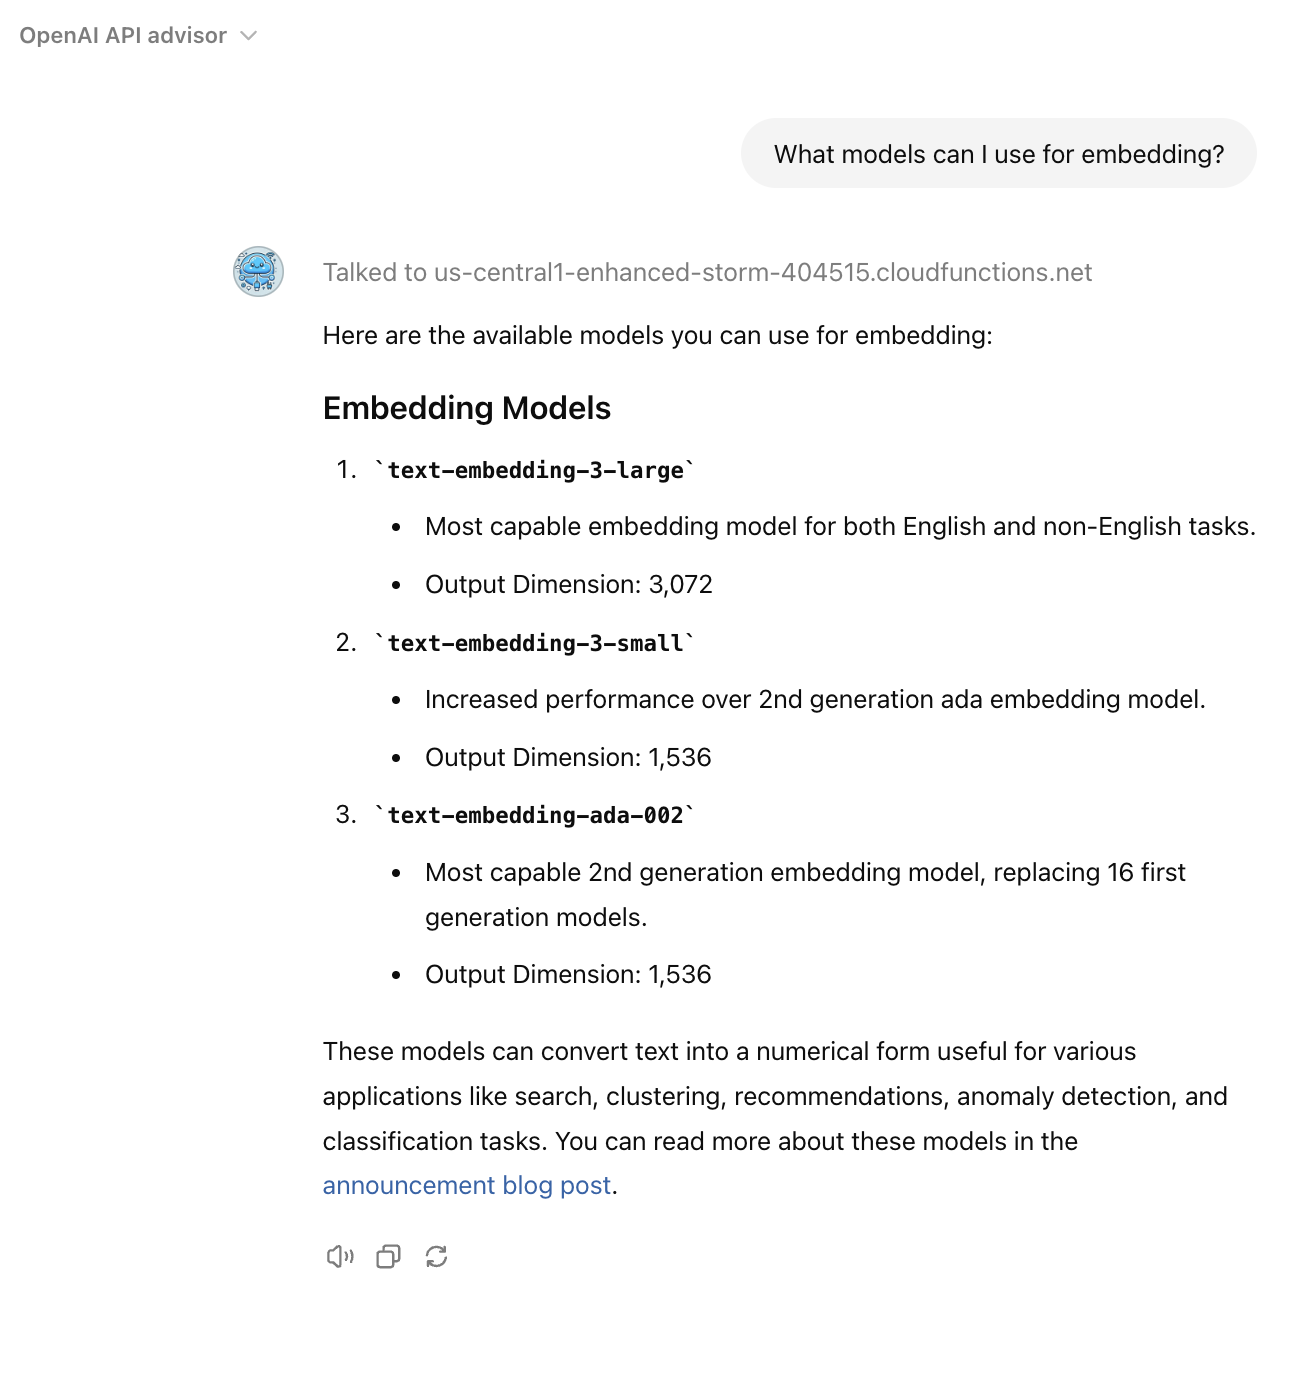